In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import scipy.stats as stats
import statsmodels.api as sm
import math
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [2]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

In [3]:
style.use('seaborn-ticks')

# QE - QT experiments

In [4]:
params_nb = {"fundamental_value": 166,
             "trader_sample_size": 22,
             "n_traders": 1000,
             "ticks": 600,
             "std_fundamental": 0.053,
             "init_assets": 740,
             'spread_max': 0.004,
             'money_multiplier': 2.2,
             "horizon": 200,
             "std_noise": 0.049,
             "w_random": 0.08,
             "strat_share_chartists": 0.08,
             "base_risk_aversion": 1.051,
             "fundamentalist_horizon_multiplier": 3.8,
             "trades_per_tick": 1, "mutation_intensity": 0.0477,
             "average_learning_ability": 0.05,
             "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
             "qe_perc_size": 0.16, "cb_size": 0.024, "qe_asset_index": 0, "qe_start": 0, "qe_end":0}

In [5]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [6]:
problem = {
  'num_vars': 7,
  'names': ['std_noise', "w_random", "strat_share_chartists",
            "base_risk_aversion", "fundamentalist_horizon_multiplier",
            "mutation_intensity", "average_learning_ability"],
  'bounds': [[0.03, 0.09], [0.02, 0.15], [0.02, 0.3],
            [0.05, 3.0], [1.0, 5.0],
            [0.05,0.5], [0.01, 0.8]]
}

In [7]:
for i, name in enumerate(problem['names']):
    params_nb[name] = est_params[i]

In [8]:
NRUNS = 15
burn_in_period = 0

In [9]:
#scenarios = [None, 'BLR', 'BUSTQE', 'BUSTQT', 'BOOMQE', 'BOOMQT']
#scenarios = ['BUSTQE']
scenarios = [None, 'BLR', 'BUSTQE', 'BOOMQT']

In [10]:
steps = 5
qe_size = [x / 100.0 for x in range(0, 100 + steps, steps)]
qe_size = qe_size[0:-12]
qe_size

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [11]:
experiments = len(qe_size)

In [12]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qe_size[exp])

In [13]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []

for scenario in scenarios:
    for exp in range(experiments):
        params_nb['qe_perc_size'] = qe_size[exp]
        trdrs = []
        orbs = []
        central_banks = []
        
        for seed_nb in range(NRUNS): 
            traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
            traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
            central_banks.append(central_bank_nb)
            trdrs.append(traders_nb)
            orbs.append(orderbook_nb)

        prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
        fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
        volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
        # bug here!!
        qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
        qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())

KeyError: 'qe_end'

## 1 Can QE mitigate downswings?
QE in bust. 

- Effect on Av prices
- detrended volatility

In [11]:
s_idx = 2
scenarios[s_idx]

'BUSTQE'

In [12]:
#qe_downswing_prices = [prices[0]]
qe_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_downswing_prices.append((prices[e] / fundamentals[e])[:-1])

In [13]:
p_averages = []
p_conf_uppers = []
p_conf_lowers = []

av_stdev_qe_downswing = []
ns_conf_uppers = []
ns_conf_lowers = []
for idx, exp_pr in enumerate(qe_downswing_prices):
    p_averages.append(np.mean(qe_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_downswing_prices[idx].mean(), np.mean(qe_downswing_prices[idx].mean()))
    p_conf_uppers.append(upper)
    p_conf_lowers.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_downswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers.append(upper)
    ns_conf_lowers.append(lower)

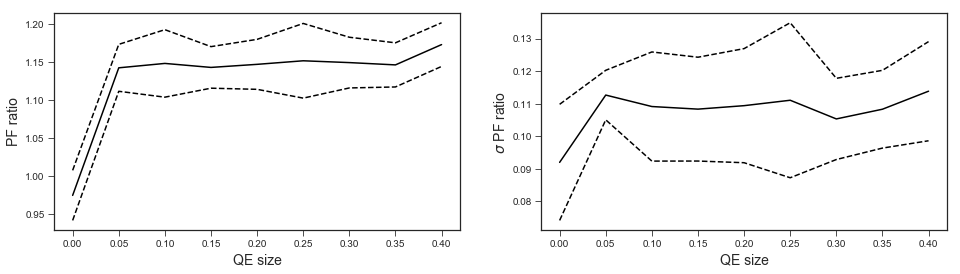

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages, 'k')
ax1.plot(qe_size, p_conf_uppers, 'k--')
ax1.plot(qe_size, p_conf_lowers, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_downswing, 'k')
ax2.plot(qe_size, ns_conf_uppers, 'k--')
ax2.plot(qe_size, ns_conf_lowers, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('BLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Next, can QT cool down asset price upswings?

QT boom

In [15]:
s_idx = 3
scenarios[s_idx]

'BOOMQT'

In [16]:
#qe_downswing_prices = [prices[0]]
qt_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_upswing_prices.append((prices[e] / fundamentals[e])[:-1])

In [17]:
p_averages_qtu = []
p_conf_uppers_qtu = []
p_conf_lowers_qtu = []

av_stdev_qt_upswing = []
ns_conf_uppers_qtu = []
ns_conf_lowers_qtu = []
for idx, exp_pr in enumerate(qt_upswing_prices):
    p_averages_qtu.append(np.mean(qt_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_upswing_prices[idx].mean(), np.mean(qt_upswing_prices[idx].mean()))
    p_conf_uppers_qtu.append(upper)
    p_conf_lowers_qtu.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_upswing_prices[idx], lamb=100000000)
    
    av_stdev_qt_upswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qtu.append(upper)
    ns_conf_lowers_qtu.append(lower)

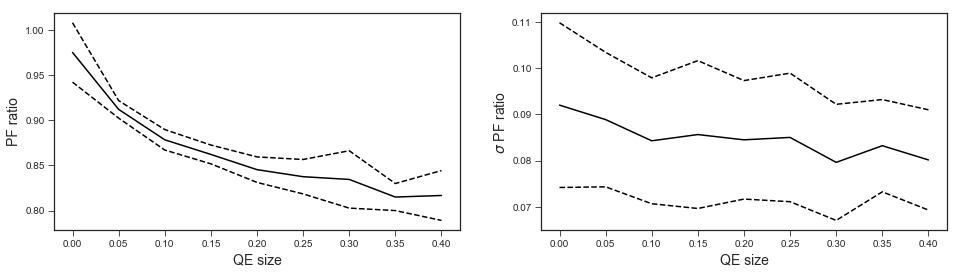

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtu, 'k')
ax1.plot(qe_size, p_conf_uppers_qtu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtu, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_qt_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtu, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('SLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Then, Can a QE-QT mix stabilize the asset price cycle?  

In [19]:
s_idx = 1
scenarios[s_idx]

'BLR'

In [20]:
#qe_downswing_prices = [prices[0]]
blr_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    blr_prices.append((prices[e] / fundamentals[e])[:-1])

In [21]:
p_averages_blr = []
p_conf_uppers_blr = []
p_conf_lowers_blr = []

av_stdev_blr = []
ns_conf_uppers_blr = []
ns_conf_lowers_blr = []
for idx, exp_pr in enumerate(blr_prices):
    p_averages_blr.append(np.mean(blr_prices[idx].mean()))
    upper, lower = confidence_interval(blr_prices[idx].mean(), np.mean(blr_prices[idx].mean()))
    p_conf_uppers_blr.append(upper)
    p_conf_lowers_blr.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(blr_prices[idx], lamb=100000000)
    
    av_stdev_blr.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_blr.append(upper)
    ns_conf_lowers_blr.append(lower)

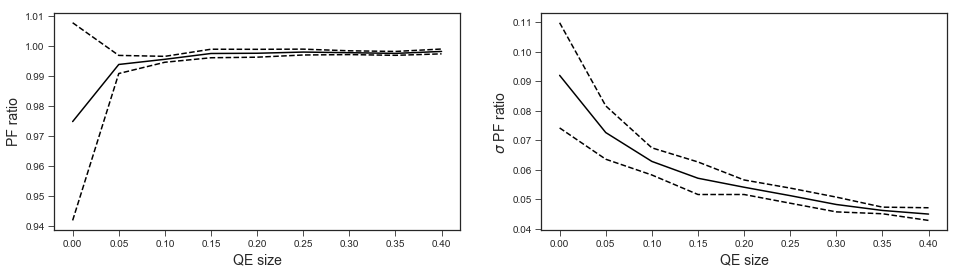

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_blr, 'k')
ax1.plot(qe_size, p_conf_uppers_blr, 'k--')
ax1.plot(qe_size, p_conf_lowers_blr, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(qe_size, av_stdev_blr, 'k')
ax2.plot(qe_size, ns_conf_uppers_blr, 'k--')
ax2.plot(qe_size, ns_conf_lowers_blr, 'k--')

ax2.set_ylabel('$\sigma$ PF ratio', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('BSLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# What if the timing is wrong? 

## a QE in an upswing

In [53]:
s_idx = 4
scenarios[s_idx]

'BOOMQE'

In [54]:
#qe_downswing_prices = [prices[0]]
qe_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_upswing_prices.append(prices[e])

In [55]:
p_averages_qeu = []
p_conf_uppers_qeu = []
p_conf_lowers_qeu = []

av_stdev_qe_upswing = []
ns_conf_uppers_qeu = []
ns_conf_lowers_qeu = []
for idx, exp_pr in enumerate(qe_upswing_prices):
    p_averages_qeu.append(np.mean(qe_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_upswing_prices[idx].mean(), np.mean(qe_upswing_prices[idx].mean()))
    p_conf_uppers_qeu.append(upper)
    p_conf_lowers_qeu.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_upswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_upswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qeu.append(upper)
    ns_conf_lowers_qeu.append(lower)

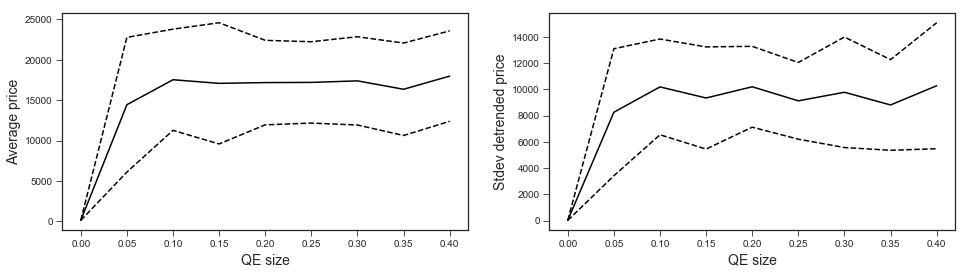

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboom.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## b QT in a downswing

In [57]:
s_idx = 3
scenarios[s_idx]

'BUSTQT'

In [58]:
#qe_downswing_prices = [prices[0]]
qt_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_downswing_prices.append(prices[e])

In [59]:
p_averages_qtd = []
p_conf_uppers_qtd = []
p_conf_lowers_qtd = []

av_stdev_qtd = []
ns_conf_uppers_qtd = []
ns_conf_lowers_qtd = []
for idx, exp_pr in enumerate(qt_downswing_prices):
    p_averages_qtd.append(np.mean(qt_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_downswing_prices[idx].mean(), np.mean(qt_downswing_prices[idx].mean()))
    p_conf_uppers_qtd.append(upper)
    p_conf_lowers_qtd.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qtd.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qtd.append(upper)
    ns_conf_lowers_qtd.append(lower)

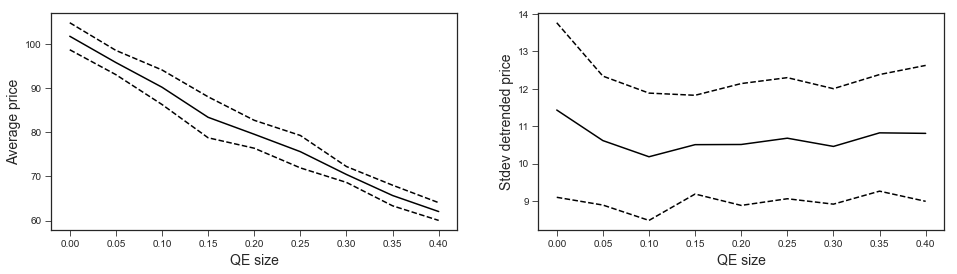

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtd, 'k')
ax1.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtd, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qtd, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Stupid policy graph summary

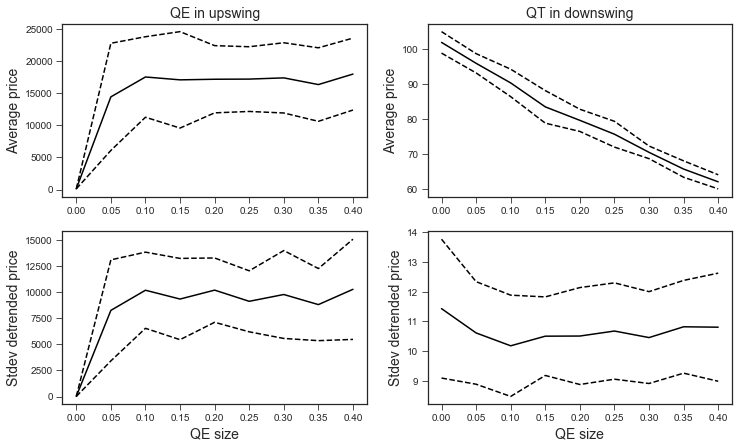

In [67]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[12,7])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')
ax1.set_title('QE in upswing', fontsize='14')

ax2.plot(qe_size, p_averages_qtd, 'k')
ax2.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, p_conf_lowers_qtd, 'k--')
ax2.set_title('QT in downswing', fontsize='14')
ax2.set_ylabel('Average price', fontsize='14')

ax3.plot(qe_size, av_stdev_qe_upswing, 'k')
ax3.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax3.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax3.set_ylabel('Stdev detrended price', fontsize='14')

ax4.plot(qe_size, av_stdev_qtd, 'k')
ax4.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax4.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax4.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboomQTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)